# Linear Model Selection and Regularization

Topics covered in this chapter of the book-

* 6.1 SubsetSelection ........................ 205 
  * 6.1.1 BestSubsetSelection ................. 205 
  * 6.1.2 StepwiseSelection ................... 207 
  * 6.1.3 ChoosingtheOptimalModel ............. 210
* 6.2 ShrinkageMethods....................... 214 
  * 6.2.1 RidgeRegression.................... 215 
  * 6.2.2 TheLasso........................ 219 
  * 6.2.3 SelectingtheTuningParameter. . . . . . . . . . . . 227
* 6.3 DimensionReductionMethods ................ 228 
  * 6.3.1 Principal Components Regression . . . . . . . . . . . 230 
  * 6.3.2 PartialLeastSquares ................. 237
* 6.4 ConsiderationsinHighDimensions . . . . . . . . . . . . . . 238 
  * 6.4.1 High-DimensionalData ................ 238 
  * 6.4.2 What Goes Wrong in High Dimensions? . . . . . . . 239 
  * 6.4.3 RegressioninHighDimensions . . . . . . . . . . . . 241 
  * 6.4.4 Interpreting Results in High Dimensions . . . . . . . 243
* 6.5 Lab1:SubsetSelectionMethods ............... 244
  * 6.5.1 BestSubsetSelection ................. 244
  * 6.5.2 Forward and Backward Stepwise Selection . . . . . . 247
  * 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation . . . . . . . . . . 248
* 6.6 Lab2:RidgeRegressionandtheLasso. . . . . . . . . . . . 251 
  * 6.6.1 RidgeRegression.................... 251 
  * 6.6.2 TheLasso........................ 255
* 6.7 Lab3:PCRandPLSRegression ............... 256 
  * 6.7.1 Principal Components Regression . . . . . . . . . . . 256 
  * 6.7.2 PartialLeastSquares ................. 258

**Following is the summary of concepts along with data and python code-**

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import time
import random
import itertools

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 
from sklearn import linear_model 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score

In this chapter, we discuss some ways in which the simple linear model can be improved, by replacing plain least squares fitting with some alternative fitting procedures.

There are many alternatives, both classical and modern, to using least squares to fit. In this chapter, we discuss three important classes of methods- 
* **Subset Selection**- This approach involves identifying a subset of the p predictors that we believe to be related to the response. We then fit a model using least squares on the reduced set of variables.

* **Shrinkage**- This approach involves fitting a model involving all p pre- dictors. However, the estimated coefficients are shrunken towards zero relative to the least squares estimates. This shrinkage (also known as regularization) has the effect of reducing variance. Depending on what type of shrinkage is performed, some of the coefficients may be esti- mated to be exactly zero. Hence, shrinkage methods can also perform variable selection.

* **Dimension Reduction**- This approach involves projecting the p predic- tors into a M-dimensional subspace, where M < p. This is achieved by computing M different linear combinations, or projections, of the variables. Then these M projections are used as predictors to fit a linear regression model by least squares.

## Subset Selection Methods

### Best Subset Selection
To perform best subset selection, we fit a separate least squares regression for each possible combination of the    predictors. The process for selecting best model looks like this-

1. Let M0 denote the null model, which contains no predictors. This model simply predicts the sample mean for each observation.


2. For k=1,2,...p:
* (a) Fit all models that contain exactly k predictors.
* (b) Pick the best among these k models, and call it Mk. Here *best* is defined as having the smallest RSS, or equivalently largest R .

3. Select a single best model from among M0, . . . , Mp using cross- validated prediction error, Cp (AIC), BIC, or adjusted R .

In [4]:
Hitters = pd.read_csv('../data/Hitters.csv', header=0, na_values='NA')
print(Hitters.shape) # get the dimension of this 
print(Hitters.head()) # pull a sample of this dataset

(322, 20)
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
0    29      14      A        E      446       33      20     NaN         A  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      33      N        E      805       40       4    91.5         N  


In [5]:
Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
Hitters.shape

(263, 20)

In [20]:
y = Hitters.Salary  # the response variable 

# change categorical variables into dummies
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']]) 

#keep n-1 dummy variables for each categorical variable with n unique value/category
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)  

In [34]:
## Functions to run on a subset of feature and extract RSS
def getRSS(y, X, feature_list):
    model = sm.OLS(y, X[list(feature_list)]).fit()
    RSS = ((model.predict(X[list(feature_list)]) - y) ** 2).sum()
    return {'Model':model, "RSS":RSS}

## Functions to select the best model on basis of RSS for given number of features
def bestModel(y, X, K):
    results = []
    for c in itertools.combinations(X.columns, K):
        results.append(getRSS(y, X, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].argmin()]
    return best_model

In [28]:
max_feature = 3
models = pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,(max_feature+1)):   
    models.loc[i] = bestModel(y, X, i)

In [33]:
# The summary() function also returns R2, RSS, adjusted R2, Cp, and BIC.
# We can examine these on each model to try to select the best overall model.
print(models)
print(models.loc[3, 'Model'].summary()) # model with 3 variables- Hits, CRBI, PutOuts is the best

            RSS                                              Model
1  4.321393e+07  <statsmodels.regression.linear_model.Regressio...
2  3.073305e+07  <statsmodels.regression.linear_model.Regressio...
3  2.943854e+07  <statsmodels.regression.linear_model.Regressio...
                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.772
Model:                            OLS   Adj. R-squared (uncentered):              0.769
Method:                 Least Squares   F-statistic:                              292.7
Date:                Fri, 23 Oct 2020   Prob (F-statistic):                    5.01e-83
Time:                        23:48:21   Log-Likelihood:                         -1902.0
No. Observations:                 263   AIC:                                      3810.
Df Residuals:                     260   BIC:                                      3821.
Df Model:                   

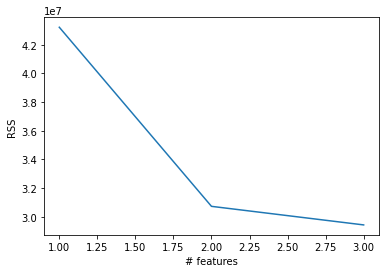

In [29]:
# Plot to show an example to plot the RSS of best models with different number of parameters
plt.figure()
plt.plot(models["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()
# RSS is falling with features- 3 variable model is the best one on the basis of RSS- we can keep adding features further to find best model 

In [30]:
rsquared_adj = models.apply(lambda a: 
                            a[1].rsquared_adj, axis=1)
rsquared_adj

1    0.663357
2    0.759667
3    0.768905
dtype: float64

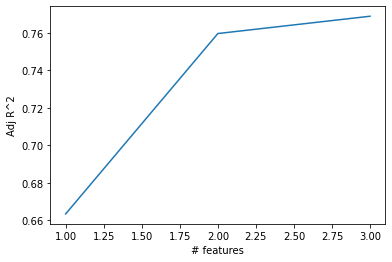

In [31]:
# Plot to show an example to plot the RSS of best models with different number of parameters
plt.figure()
plt.plot(rsquared_adj)
plt.xlabel('# features')
plt.ylabel('Adj R^2')
plt.show()
# Adj R2 is increasing with features - 3 variable model is the best one on the basis of Adj R2 - we can keep adding features further to find best model 


### Forward Stepwise Selection

Forward stepwise selection is a computationally efficient alternative to best subset selection. While the best subset selection procedure considers all 2p possible models containing subsets of the p predictors, forward step- wise considers a much smaller set of models. Forward stepwise selection begins with a model containing no predictors, and then adds predictors to the model, one-at-a-time, until all of the predictors are in the model. In particular, at each step the variable that gives the greatest additional improvement to the fit is added to the model. 

1. Let M0 denote the null model, which contains no predictors.


2. For k=0,...,p−1:
* (a) Consider all p − k models that augment the predictors in Mk with one additional predictor.
* (b) Choose the best among these p − k models, and call it Mk+1. Here best is defined as having smallest RSS or highest R .

3. Select a single best model from among M0, . . . , Mp using cross-validated prediction error, Cp (AIC), BIC, or adjusted R .
 

In [35]:
def forward_select(y, X, feature_list):
    remaining_predictors = [p for p in X.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS(y, X, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model 

In [41]:
max_feature = 15
models2 = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,max_feature+1):
    models2.loc[i] = forward_select(y, X, feature_list)
    feature_list = models2.loc[i]["Model"].model.exog_names

In [42]:
print(models2)
print(models2.loc[3, 'Model'].summary())
# RSS is falling with features

             RSS                                              Model
1   4.321393e+07  <statsmodels.regression.linear_model.Regressio...
2   3.073305e+07  <statsmodels.regression.linear_model.Regressio...
3   2.943854e+07  <statsmodels.regression.linear_model.Regressio...
4   2.826074e+07  <statsmodels.regression.linear_model.Regressio...
5   2.717538e+07  <statsmodels.regression.linear_model.Regressio...
6   2.621956e+07  <statsmodels.regression.linear_model.Regressio...
7   2.596156e+07  <statsmodels.regression.linear_model.Regressio...
8   2.516030e+07  <statsmodels.regression.linear_model.Regressio...
9   2.483520e+07  <statsmodels.regression.linear_model.Regressio...
10  2.455470e+07  <statsmodels.regression.linear_model.Regressio...
11  2.446856e+07  <statsmodels.regression.linear_model.Regressio...
12  2.441054e+07  <statsmodels.regression.linear_model.Regressio...
13  2.438377e+07  <statsmodels.regression.linear_model.Regressio...
14  2.435901e+07  <statsmodels.regression.linear

In [46]:
rsquared_adj = models2.apply(lambda a: 
                            a[1].rsquared_adj, axis=1)
print(rsquared_adj)
# Adj R^2 is increasing with features
# R^2 increasing & RSS lowering but adj R^2 is falling post 10 p hence, we dont need more than 10 p, others are insignificant.


1     0.663357
2     0.759667
3     0.768905
4     0.777294
5     0.785017
6     0.791772
7     0.793015
8     0.798617
9     0.800436
10    0.801910
11    0.801822
12    0.801504
13    0.800929
14    0.800332
15    0.799698
dtype: float64


### Backward Stepwise Selection

Like forward stepwise selection, backward stepwise selection provides an efficient alternative to best subset selection. However, unlike forward stepwise selection, it begins with the full least squares model containing all p predictors, and then iteratively removes the least useful predictor, one-at-a-time. 

1. Let Mp denote the full model, which contains all p predictors.


2. For k=p,p−1,...,1:

* (a) Consider all k models that contain all but one of the predictors in Mk, for a total of k − 1 predictors.
* (b) Choose the best among these k models, and call it Mk−1. Here best is defined as having smallest RSS or highest R.

3. Select a single best model from among M0, . . . , Mp using cross-validated prediction error, Cp (AIC), BIC, or adjusted R .

In [47]:
def backward_select(y, X, feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS(y, X, combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model 

In [58]:
models3 = pd.DataFrame(columns=["RSS", "Model"], index = range(1,len(X.columns)))
feature_list = X.columns

while(len(feature_list) > 1):
    models3.loc[len(feature_list)-1] = backward_select(y, X, feature_list)
    feature_list = models3.loc[len(feature_list)-1]["Model"].model.exog_names

In [57]:
rsquared_adj = models3.apply(lambda a: 
                            a[1].rsquared_adj, axis=1)
print(models3.iloc[:,0])
print(rsquared_adj)
# R^2 increasing & RSS lowering but adj R^2 is falling post 10 p hence, we dont need more than 10 p, others are insignificant

1     4.32139e+07
2     3.13002e+07
3     2.96395e+07
4     2.84592e+07
5     2.75168e+07
6     2.67055e+07
7     2.59362e+07
8     2.51603e+07
9     2.48352e+07
10    2.45547e+07
11    2.44686e+07
12    2.44105e+07
13    2.43838e+07
14     2.4359e+07
15    2.43383e+07
16    2.43192e+07
17    2.43037e+07
18    2.42965e+07
Name: RSS, dtype: object
1     0.663357
2     0.755232
3     0.767327
4     0.775731
5     0.782317
6     0.787913
7     0.793218
8     0.798617
9     0.800436
10    0.801910
11    0.801822
12    0.801504
13    0.800929
14    0.800332
15    0.799698
16    0.799045
17    0.798357
18    0.797593
dtype: float64


## Shrinkage Methods

### Ridge Regression and the Lasso

Ridge regression is very similar to least squares, except that the coefficients are estimated by minimizing a slightly different quantity. In particular, the ridge regression coefficient estimates βˆR are the values that minimize
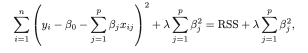

where λ ≥ 0 is a tuning parameter, to be determined separately. Equation trades off two different criteria. As with least squares, ridge regression seeks coefficient estimates that fit the data well, by making the RSS small. However, the second term, called a shrinkage penalty, is small when β1, . . . , βp are close to zero, and so it has the effect of shrinking the estimates of βj towards zero.

In [97]:
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [98]:
Hitters = pd.read_csv('../data/Hitters.csv', header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])

y = Hitters.Salary  # the response variable 
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

In [99]:
X_train, X_test , y_train, y_test = train_test_split(X, y)

In [102]:
ridge = Ridge(fit_intercept=True, normalize=True, alpha=4)
ridgemodel = ridge.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))        # Calculate the test MSE

AtBat           0.094214
Hits            0.425688
HmRun           1.393435
Runs            0.667159
RBI             0.696568
Walks           1.053478
Years           2.479727
CAtBat          0.008734
CHits           0.035571
CHmRun          0.290251
CRuns           0.078347
CRBI            0.071455
CWalks          0.080231
PutOuts         0.073132
Assists         0.009901
Errors         -0.120890
League_A       -8.035691
Division_E     38.755126
NewLeague_A    -5.881910
dtype: float64
75728.85761302235


Ridge(alpha=4, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [105]:
RidgeCV?

In [106]:
ridgecv =  RidgeCV(alpha, normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.01

In [107]:
ridge_best = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge_best.fit(X_train, y_train)
mean_squared_error(y_test, ridge_best.predict(X_test))

80032.16337972828

In [109]:
pd.Series(ridge_best.coef_, index=X.columns)

AtBat           -1.937886
Hits             6.125915
HmRun           -0.915264
Runs            -1.018186
RBI              0.791576
Walks            6.247442
Years          -15.849746
CAtBat          -0.085709
CHits            0.251573
CHmRun           1.654119
CRuns            0.985110
CRBI             0.041817
CWalks          -0.539329
PutOuts          0.256748
Assists          0.316338
Errors          -1.251228
League_A       -98.739059
Division_E     144.956790
NewLeague_A     56.504161
dtype: float64

### We saw that ridge regression with a wise choice of λ can outperform least squares as well as the null model on the Hitters data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression.

In [113]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=1e5, normalize=True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

76680.11673280169

In [114]:
# Some of the coefficients should reduce to exact zero
pd.Series(lasso.coef_, index=X.columns)

AtBat           -1.792745
Hits             5.933814
HmRun           -0.000000
Runs            -0.000000
RBI              0.000000
Walks            5.254110
Years          -13.832284
CAtBat          -0.000000
CHits            0.000000
CHmRun           1.540912
CRuns            0.820241
CRBI             0.000000
CWalks          -0.400841
PutOuts          0.257400
Assists          0.201540
Errors          -0.000000
League_A       -45.697486
Division_E     143.328128
NewLeague_A      0.000000
dtype: float64